# 3. Characterizing outperformed & underperformed companies 1-Month Post-COVID19 Vaccine Success

## Instructions
In 2020 August, the author attempted a characterization of [S&P500 companies based on fundamental metrics during covid19](https://medium.com/analytics-vidhya/characterising-companies-based-on-financial-metrics-during-covid19-1a6ce9cc4ada). Here, the author sought to characterize the performance of S&P500 companies 1-month after [the first covid19 vaccine success announcement by Pfizer](https://www.pfizer.com/news/press-release/press-release-detail/pfizer-and-biontech-conclude-phase-3-study-covid-19-vaccine) on the Nov 18, 2020. Briefly, the stock return was calculated based on the difference between the end of day (eod) stock prices on the Nov 17 and Dec 18, 2020. The contemporary fundamental metrics of the companies were retrieved to investigate their correlations with the top and worst performer during the month.

## Packages
You'll need to you install the quanp package (https://quanp.readthedocs.io/en/latest/installation.html) that should install all necessary packages/libraries required to execute the codes in this tutorial. Please create and use virtualenv with python version 3.6 to avoid dependency problem.

### Install Packages

In [1]:
# import sys
# !conda install seaborn scikit-learn statsmodels numba pytables
# !conda install -c conda-forge python-igraph leidenalg
# !{sys.executable} -m pip install quanp

In [30]:
# importing library packages
from datetime import datetime, timedelta
import os

import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import quanp as qp
import re

from IPython.display import display
from matplotlib import rcParams

# setting visualization/logging parameters
pd.set_option('display.max_columns', None)
qp.set_figure_params(dpi=100, color_map = 'viridis_r')
qp.settings.verbosity = 1
qp.logging.print_versions()

### Download data
Here, we get the 505 S&P500 member companies listed on the wikipedia & get a list of fundamental metrics for each company from the TD Ameritrade API (All functions are available from the quanp tools).

In [56]:
# S&P 500 metadata
df_metadata = qp.datasets.get_wiki_sp500_metadata()

# # S&P 500 fundamentals
# df_fundamental = qp.datasets.download_tickers_fundamental()

# # Download End of Day (eod) price history from the current sp500 list
# qp.datasets.download_tickers_price_history_fromlist(df_metadata.index)

The metadata file has been initialized and saved as /Users/leehongkai/OneDrive/Finance/quanp/notebooks/data/metadata/sp500_metadata.csv


### Loading and preparing data

In [57]:
# Optional: The data retried in cell above were saved as csv file. You may execute this cell to avoid 
# rerunning the downloading cell above.
df_fundamental = pd.read_csv('data/metadata/sp500_metadata_fundamentalAdded.csv', index_col=0)
print(df_fundamental.columns)

Index(['Security', 'SEC filings', 'GICS Sector', 'GICS Sub-Industry',
       'Headquarters Location', 'Date first added', 'CIK', 'Founded', 'beta',
       'bookValuePerShare', 'currentRatio', 'divGrowthRate3Year',
       'dividendAmount', 'dividendDate', 'dividendPayAmount',
       'dividendPayDate', 'dividendYield', 'epsChange', 'epsChangePercentTTM',
       'epsChangeYear', 'epsTTM', 'grossMarginMRQ', 'grossMarginTTM', 'high52',
       'interestCoverage', 'low52', 'ltDebtToEquity', 'marketCap',
       'marketCapFloat', 'netProfitMarginMRQ', 'netProfitMarginTTM',
       'operatingMarginMRQ', 'operatingMarginTTM', 'pbRatio', 'pcfRatio',
       'peRatio', 'pegRatio', 'prRatio', 'quickRatio', 'returnOnAssets',
       'returnOnEquity', 'returnOnInvestment', 'revChangeIn', 'revChangeTTM',
       'revChangeYear', 'sharesOutstanding', 'shortIntDayToCover',
       'shortIntToFloat', 'symbol', 'totalDebtToCapital', 'totalDebtToEquity',
       'vol10DayAvg', 'vol1DayAvg', 'vol3MonthAvg'],
     

In [58]:
# prepare End of Day (eod) for each company
df_eod = qp.datasets.process_eod_price(df_metadata.index, startdate='2020-11-17', enddate='2020-12-18')

display(df_eod[:2])
display(df_eod[-2:])

BRK.B was excluded as the ticker csv was not found in the  /Users/leehongkai/OneDrive/Finance/quanp/notebooks/data/daily
BF.B was excluded as the ticker csv was not found in the  /Users/leehongkai/OneDrive/Finance/quanp/notebooks/data/daily


MMM     ABT   ABBV    ABMD     ACN   ATVI  \
2020-11-17 00:00:00+00:00  173.64  113.06  99.21  269.93  243.82  77.11   
2020-11-18 00:00:00+00:00  171.40  109.77  98.72  266.21  239.73  75.50   

                             ADBE    AMD    AAP    AES    AFL       A     APD  \
2020-11-17 00:00:00+00:00  467.95  83.36  149.3  21.35  43.00  109.86  266.29   
2020-11-18 00:00:00+00:00  459.47  82.54  148.1  21.37  42.86  105.95  267.70   

                             AKAM    ALK     ALB     ARE    ALXN    ALGN  \
2020-11-17 00:00:00+00:00  102.45  47.46  127.95  165.29  127.69  451.38   
2020-11-18 00:00:00+00:00  100.59  47.72  126.54  162.53  123.47  444.61   

                             ALLE    LNT     ALL    GOOGL     GOOG     MO  \
2020-11-17 00:00:00+00:00  115.46  54.73   99.37  1761.66  1770.15  41.19   
2020-11-18 00:00:00+00:00  114.56  53.06  100.07  1740.64  1746.78  40.17   

                              AMZN   AMCR    AEE    AAL    AEP     AXP    AIG  \
2020-11-17 00:00:00+00:00  3135.66  11.93  80.60  12.70  86.73  116.48  38.42   
2020-11-18 00:00:00+00:00  3105.46  11.84  79.06  12.74  84.13  114.24  38.55   

                              AMT     AWK     AMP     ABC     AME    AMGN  \
2020-11-17 00:00:00+00:00  239.18  159.29  184.23  104.89  118.76  232.44   
2020-11-18 00:00:00+00:00  237.70  156.19  183.33  103.44  119.24  227.76   

                              APH     ADI    ANSS    ANTM     AON    AOS  \
2020-11-17 00:00:00+00:00  127.06  135.87  319.79  329.84  207.19  56.38   
2020-11-18 00:00:00+00:00  125.80  133.23  317.99  322.38  203.36  56.49   

                             APA    AAPL   AMAT    APTV    ADM    ANET  \
2020-11-17 00:00:00+00:00  11.44  119.39  74.37  114.44  50.16  277.78   
2020-11-18 00:00:00+00:00  11.04  118.03  75.71  115.05  49.27  272.03   

                              AJG     AIZ      T     ATO    ADSK     ADP  \
2020-11-17 00:00:00+00:00  117.08  138.59  29.03  100.05  252.71  176.15   
2020-11-18 00:00:00+00:00  115.45  135.62  28.62   96.17  252.22  173.16   

                               AZO     AVB     AVY    BKR    BLL    BAC  \
2020-11-17 00:00:00+00:00  1124.21  174.12  149.44  19.26  97.14  27.55   
2020-11-18 00:00:00+00:00  1131.65  169.60  147.43  18.58  96.56  26.98   

                              BK    BAX     BDX     BBY     BIO    BIIB  \
2020-11-17 00:00:00+00:00  39.44  80.78  242.41  119.02  592.57  248.81   
2020-11-18 00:00:00+00:00  38.74  80.42  233.47  117.77  578.98  240.98   

                              BLK      BA     BKNG    BWA    BXP    BSX  \
2020-11-17 00:00:00+00:00  667.49  210.05  2081.25  38.00  98.46  35.03   
2020-11-18 00:00:00+00:00  669.89  203.30  2044.60  38.36  96.12  34.26   

                             BMY    AVGO      BR   CHRW    COG    CDNS    CPB  \
2020-11-17 00:00:00+00:00  64.32  380.60  147.28  93.55  17.18  113.48  49.38   
2020-11-18 00:00:00+00:00  62.01  380.62  145.77  92.88  16.74  111.03  49.04   

                             COF    CAH    KMX    CCL   CARR    CTLT     CAT  \
2020-11-17 00:00:00+00:00  87.76  54.68  94.73  18.05  40.36  104.97  171.91   
2020-11-18 00:00:00+00:00  85.61  53.32  92.82  17.59  39.39  103.14  172.74   

                            CBOE   CBRE     CDW      CE    CNC    CNP   CERN  \
2020-11-17 00:00:00+00:00  86.80  60.49  136.78  132.41  67.28  25.17  74.77   
2020-11-18 00:00:00+00:00  88.66  58.13  135.73  133.21  65.96  23.75  72.92   

                              CF  SCHW    CHTR    CVX      CMG      CB    CHD  \
2020-11-17 00:00:00+00:00  32.22  48.9  641.51  87.04  1268.48  150.03  87.21   
2020-11-18 00:00:00+00:00  32.45  47.7  642.44  84.28  1296.00  149.28  86.00   

                               CI    CINF    CTAS   CSCO      C    CFG  \
2020-11-17 00:00:00+00:00  214.81  79.705  361.41  41.88  50.73  33.07   
2020-11-18 00:00:00+00:00  210.93  79.500  360.49  41.32  51.05  32.51   

                             CTXS     CLX     CME    CMS     KO  CTSH  

MMM     ABT    ABBV    ABMD     ACN   ATVI  \
2020-12-17 00:00:00+00:00  176.65  108.78  104.89  281.99  264.47  88.46   
2020-12-18 00:00:00+00:00  176.42  108.97  104.45  293.39  266.25  90.37   

                             ADBE    AMD     AAP    AES    AFL       A  \
2020-12-17 00:00:00+00:00  495.36  96.84  160.34  22.09  44.81  118.97   
2020-12-18 00:00:00+00:00  502.95  95.92  159.99  22.54  43.89  119.30   

                              APD    AKAM    ALK     ALB     ARE    ALXN  \
2020-12-17 00:00:00+00:00  268.60  105.61  50.17  137.48  177.70  157.93   
2020-12-18 00:00:00+00:00  269.55  107.08  50.35  138.90  175.26  156.75   

                             ALGN    ALLE    LNT     ALL    GOOGL     GOOG  \
2020-12-17 00:00:00+00:00  526.72  112.82  51.73  106.56  1740.51  1747.90   
2020-12-18 00:00:00+00:00  529.92  113.75  51.05  107.40  1726.22  1731.01   

                              MO     AMZN   AMCR    AEE    AAL    AEP     AXP  \
2020-12-17 00:00:00+00:00  43.00  3236.08  11.56  78.74  16.80  83.86  118.98   
2020-12-18 00:00:00+00:00  43.78  3201.65  11.66  78.86  16.51  83.29  117.51   

                             AIG     AMT     AWK     AMP    ABC     AME  \
2020-12-17 00:00:00+00:00  38.23  222.71  151.86  190.05  98.74  117.63   
2020-12-18 00:00:00+00:00  37.48  221.52  150.24  186.94  98.61  118.10   

                             AMGN     APH     ADI    ANSS    ANTM     AON  \
2020-12-17 00:00:00+00:00  231.24  132.17  143.78  346.63  314.08  211.30   
2020-12-18 00:00:00+00:00  228.49  130.65  144.56  357.81  308.64  205.49   

                             AOS    APA     AAPL   AMAT    APTV    ADM  \
2020-12-17 00:00:00+00:00  55.26  15.75  128.700  87.50  124.89  49.38   
2020-12-18 00:00:00+00:00  55.64  15.33  126.655  86.09  124.30  49.68   

                             ANET     AJG     AIZ      T    ATO    ADSK  \
2020-12-17 00:00:00+00:00  285.37  128.19  132.37  29.62  99.09  297.35   
2020-12-18 00:00:00+00:00  287.72  125.32  131.29  29.40  95.11  305.00   

                              ADP      AZO     AVB     AVY    BKR    BLL  \
2020-12-17 00:00:00+00:00  177.34  1180.89  163.23  152.23  21.50  91.98   
2020-12-18 00:00:00+00:00  179.24  1181.90  158.44  152.96  21.17  92.19   

                             BAC     BK    BAX     BDX     BBY     BIO  \
2020-12-17 00:00:00+00:00  28.83  40.41  81.04  248.70  102.34  584.24   
2020-12-18 00:00:00+00:00  28.67  40.79  80.86  252.09  101.95  605.87   

                             BIIB     BLK      BA     BKNG    BWA     BXP  \
2020-12-17 00:00:00+00:00  250.24  706.01  221.24  2113.43  39.00  100.42   
2020-12-18 00:00:00+00:00  249.62  698.80  219.75  2099.65  38.62   96.11   

                             BSX    BMY    AVGO      BR   CHRW    COG    CDNS  \
2020-12-17 00:00:00+00:00  35.39  62.54  426.10  150.83  92.29  17.23  127.30   
2020-12-18 00:00:00+00:00  35.45  63.12  434.56  153.88  92.60  16.97  132.02   

                             CPB    COF    CAH    KMX    CCL   CARR    CTLT  \
2020-12-17 00:00:00+00:00  47.78  94.08  54.22  99.79  21.63  38.70  103.62   
2020-12-18 00:00:00+00:00  47.57  91.57  54.96  98.25  21.46  38.79  105.00   

                              CAT   CBOE   CBRE     CDW      CE    CNC    CNP  \
2020-12-17 00:00:00+00:00  179.17  89.54  64.41  135.24  130.96  62.09  21.88   
2020-12-18 00:00:00+00:00  180.96  90.78  63.29  134.37  131.76  61.15  21.87   

                            CERN     CF   SCHW    CHTR    CVX      CMG  \
2020-12-17 00:00:00+00:00  78.16  37.54  51.78  653.98  88.41  1409.68   
2020-12-18 00:00:00+00:00  77.60  37.64  51.98  652.00  87.19  1418.57   

                               CB    CHD      CI   CINF    CTAS   CSCO      C  \
2020-12-17 00:00:00+00:00  153.41  87.21  202.63  84.29  352.00  44.82  60.05   
2020-12-18 00:00:00+00:00  152.36  88.15  197.08  83.04  354.35  45.44  59.06   

                             CFG    CTXS     CLX     CME    CMS     KO   CTSH  \
2020-

In [59]:
# calculate the 1-month log return of the stock price for each company, i.e. price difference
# between Nov 17 and Dec 18, 2020.
df_log_return_1mth = pd.DataFrame(np.log(df_eod.iloc[-1]) - np.log(df_eod.iloc[0]), 
                                  columns=['log_return_1mth'])

# merging fundamental data with the log_return data
df_fundamental_logreturn = pd.merge(df_fundamental, df_log_return_1mth, how='inner', left_index=True, 
                                    right_index=True)

# describe the 1-month log return of all sp500 companies.
df_fundamental_logreturn['log_return_1mth'].describe()

count    503.000000
mean       0.034189
std        0.078201
min       -0.194942
25%       -0.015173
50%        0.021695
75%        0.068664
max        0.453485
Name: log_return_1mth, dtype: float64

In [60]:
ls_fundamental_target = ['log_return_1mth'] + ['beta','bookValuePerShare','currentRatio', 'quickRatio', 
'dividendYield', 'epsChangePercentTTM', 'epsChangeYear', 'epsTTM', 'grossMarginMRQ', 'grossMarginTTM', 
'interestCoverage', 'marketCap', 'marketCapFloat', 'netProfitMarginMRQ','netProfitMarginTTM', 
'operatingMarginMRQ', 'operatingMarginTTM', 'peRatio', 'pegRatio', 'pbRatio', 'pcfRatio',
'prRatio', 'returnOnAssets', 'returnOnEquity', 'returnOnInvestment', 'revChangeIn', 'revChangeTTM', 
'revChangeYear', 'sharesOutstanding', 'shortIntDayToCover', 'shortIntToFloat', 'totalDebtToCapital', 
'totalDebtToEquity', 'ltDebtToEquity', 'vol10DayAvg', 'vol1DayAvg', 'vol3MonthAvg']

In [61]:
from sklearn.preprocessing import MinMaxScaler

# Minmax scaling (0, 1) for all the variables/features
scaler = MinMaxScaler((0, 1))
df_fundamental_logreturn_minmax = pd.DataFrame(scaler.fit_transform(df_fundamental_logreturn[ls_fundamental_target]), 
                                  index=df_fundamental_logreturn.index,
                                  columns=ls_fundamental_target)

df_fundamental_logreturn_minmax[ls_fundamental_target].describe()

log_return_1mth        beta  bookValuePerShare  currentRatio  \
count       503.000000  503.000000         503.000000    503.000000   
mean          0.353365    0.226347           0.056875      0.145271   
std           0.120602    0.116664           0.079418      0.119241   
min           0.000000    0.000000           0.000000      0.000000   
25%           0.277238    0.157283           0.000000      0.078093   
50%           0.334096    0.217107           0.039281      0.127539   
75%           0.406531    0.285650           0.074949      0.195404   
max           1.000000    1.000000           1.000000      1.000000   

       quickRatio  dividendYield  epsChangePercentTTM  epsChangeYear  \
count  503.000000     503.000000         5.030000e+02     503.000000   
mean     0.114280       0.184364         1.989590e-03       0.016070   
std      0.125906       0.176910         4.458773e-02       0.056459   
min      0.000000       0.000000         0.000000e+00       0.000000   
25%      0.000000       0.021329         0.000000e+00       0.000000   
50%      0.097960       0.147817         0.000000e+00       0.001366   
75%      0.162827       0.290675         8.397892e-07       0.011987   
max      1.000000       1.000000         1.000000e+00       1.000000   

           epsTTM  grossMarginMRQ  grossMarginTTM  interestCoverage  \
count  503.000000      503.000000      503.000000        503.000000   
mean     0.024672        0.403637        0.412475          0.006728   
std      0.057981        0.259537        0.264081          0.051631   
min      0.000000        0.000000        0.000000          0.000000   
25%      0.005598        0.208339        0.217849          0.000187   
50%      0.015117        0.405001        0.411348          0.001212   
75%      0.027749        0.607227        0.612949          0.003111   
max      1.000000        1.000000        1.000000          1.000000   

        marketCap  marketCapFloat  netProfitMarginMRQ  netProfitMarginTTM  \
count  503.000000      503.000000          503.000000          503.000000   
mean     0.029232        0.035193            0.067435            0.085000   
std      0.079591        0.071170            0.067395            0.086340   
min      0.000000        0.000000            0.000000            0.000000   
25%      0.005001        0.008167            0.025067            0.028863   
50%      0.010134        0.016803            0.057756            0.069392   
75%      0.024011        0.034315            0.096650            0.118865   
max      1.000000        1.000000            1.000000            1.000000   

       operatingMarginMRQ  operatingMarginTTM     peRatio    pegRatio  \
count          503.000000          503.000000  503.000000  503.000000   
mean             0.267448            0.239645    0.010920    0.005163   
std              0.195124            0.183059    0.047321    0.051840   
min              0.000000            0.000000    0.000000    0.000000   
25%              0.119914            0.103099    0.003518    0.000000   
50%              0.246738            0.220733    0.006269    0.000000   
75%              0.379776            0.339604    0.009728    0.001298   
max              1.000000            1.000000    1.000000    1.000000   

          pbRatio    pcfRatio     prRatio  returnOnAssets  returnOnEquity  \
count  503.000000  503.000000  503.000000      503.000000      503.000000   
mean     0.011726    0.033014    0.133036        0.121769        0.009609   
std      0.051304    0.055139    0.138410        0.134736        0.059772   
min      0.000000    0.000000    0.000000        0.000000        0.000000   
25%      0.001694    0.013778    0.044892        0.021036        0.000780   
50%      0.003511    0.022887    0.085881        0.083621        0.002106   
75%      0.007707    0.035563    0.170012        0.171502        0.004450   
max      1.000000    1.000000    1.000000        1.000000        1.000000   

       returnOnInvestment  revCh

In [62]:
# Loading pandas dataframe as anndata 
adata = qp.AnnData(df_fundamental_logreturn_minmax[ls_fundamental_target])

# Saving raw data for visualization later
adata.raw = adata

# log(x+1) transformation for all data
qp.pp.log1p(adata)

# Standardization scaling per feature
qp.pp.scale(adata)

In [63]:
# add a new `.obs` column for all comapnanies called `GICS_Sector`
adata.obs['GICS_Sector'] = df_fundamental_logreturn['GICS Sector'].values

adata

AnnData object with n_obs × n_vars = 503 × 38
    obs: 'GICS_Sector'
    var: 'mean', 'std'
    uns: 'log1p'

### Principal component analysis (PCA)
Reduce the dimensionality of the data by running PCA, which reveals the main axes of variation and denoises the data.

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function ```qp.tl.leiden()```, ```qp.tl.louvain()```, or ```tSNE qp.tl.tsne()```. In our experience, often, a rough estimate of the number of PCs does fine. The 'elbow' point seems to suggest at least up to PC5 will be useful to characterize the companies. We are going to do further dimensional reduction based on the first 6 PCs later. We will perform a factor analysis to check for the underlying features that made up these PCs in a separate tutorial notebook later.

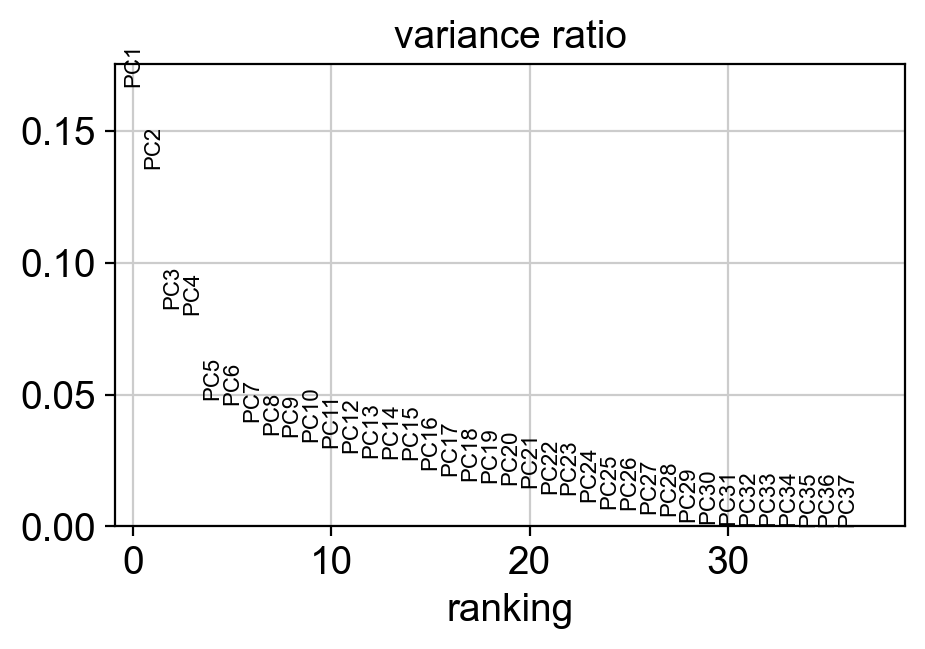

In [64]:
rcParams['figure.figsize'] = 5,3
qp.tl.pca(adata, svd_solver='arpack', random_state=42)
qp.pl.pca_variance_ratio(adata, n_pcs=len(adata.var_names))

In [65]:
# Optional: save the anndata in h5ad for reloading of the processed data later
adata.write('data/sp500_1mthlogreturn_afterVaccineSuccess.h5ad')
# adata.read('data/sp500_1mthlogreturn_afterVaccineSuccess.h5ad')
adata

/Users/leehongkai/anaconda/envs/quanp_py36/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

... storing 'GICS_Sector' as categorical


AnnData object with n_obs × n_vars = 503 × 38
    obs: 'GICS_Sector'
    var: 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

### Computing the T-distributed Stochastic Neighbor Embedding (tSNE)

Let us further reduce the dimensionality of the signficant PCs identified above wholly in to 2 dimensions using the tSNE tool implemented as ```qp.tl.tsne(adata)```.

In [66]:
qp.tl.tsne(adata, n_pcs=5, random_state=42); # only consider the first 8 pcs

### Computing the neighborhood graph

Before we view the tsne plots with Sector annotations, Let us compute the neighborhood graph of companies using the PCA representation of the data matrix. This will give rise to distances and connectivities in each company. Here, we consider 10 nearest neighbors with 5 PCs derived from the PCA

In [67]:
qp.pp.neighbors(adata, n_neighbors=10, n_pcs=5, random_state=42);

### Clustering the neighborhood graph

Here, we use Leiden graph-clustering method (community detection based on optimizing modularity) by Traag *et al.* (2018) to cluster the neighborhood graph of companies, which we already computed in the previous section.

In [68]:
qp.tl.leiden(adata)

We can now map and view the annotations of leiden clustering, GICS_Sector, or any financial metrics/features on the tsne plots. We can see that companies from the Leiden Clusters 8 and 9 seems to perform the best 1 month post-vaccine-success, while the worst performers seem to be ones from the Clusters 7 and 6.

In [69]:
# # Check data distribution of the log_return_1mth to set a appropriate vmin cutoff
df_fundamental_logreturn_minmax['log_return_1mth'].describe()

count    503.000000
mean       0.353365
std        0.120602
min        0.000000
25%        0.277238
50%        0.334096
75%        0.406531
max        1.000000
Name: log_return_1mth, dtype: float64

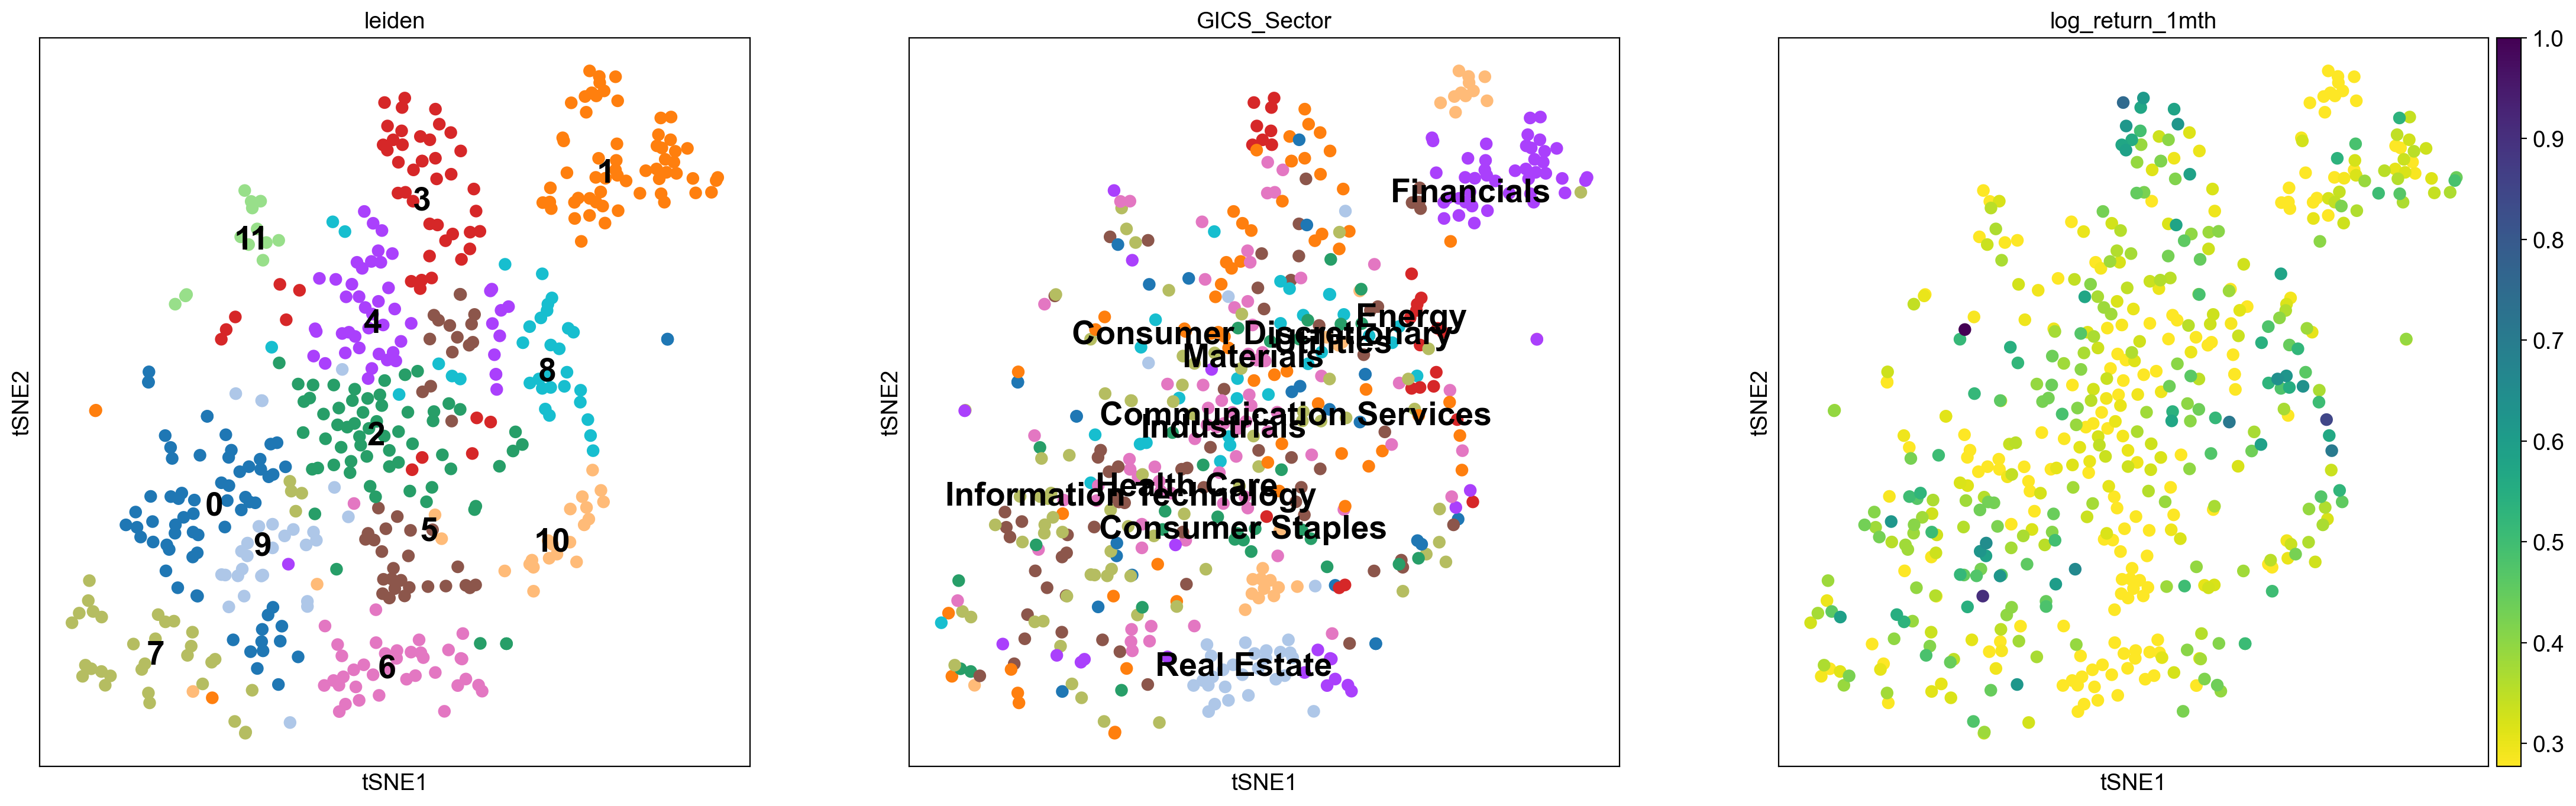

In [70]:
rcParams['figure.figsize'] = 8,8
qp.pl.tsne(adata, color=['leiden', 'GICS_Sector', 'log_return_1mth'], 
           vmin=0.277238, legend_loc='on data', use_raw=True, legend_fontsize=20)

### Embedding the neighborhood graph

We can also embed the neighborhood graph in 2 dimensions using UMAP (McInnes et al., 2018), see below. It is potentially more faithful to the global connectivity of the manifold than tSNE. Before running the UMAP, we compute the correlations between clusters as initiating positions for the UMAP.

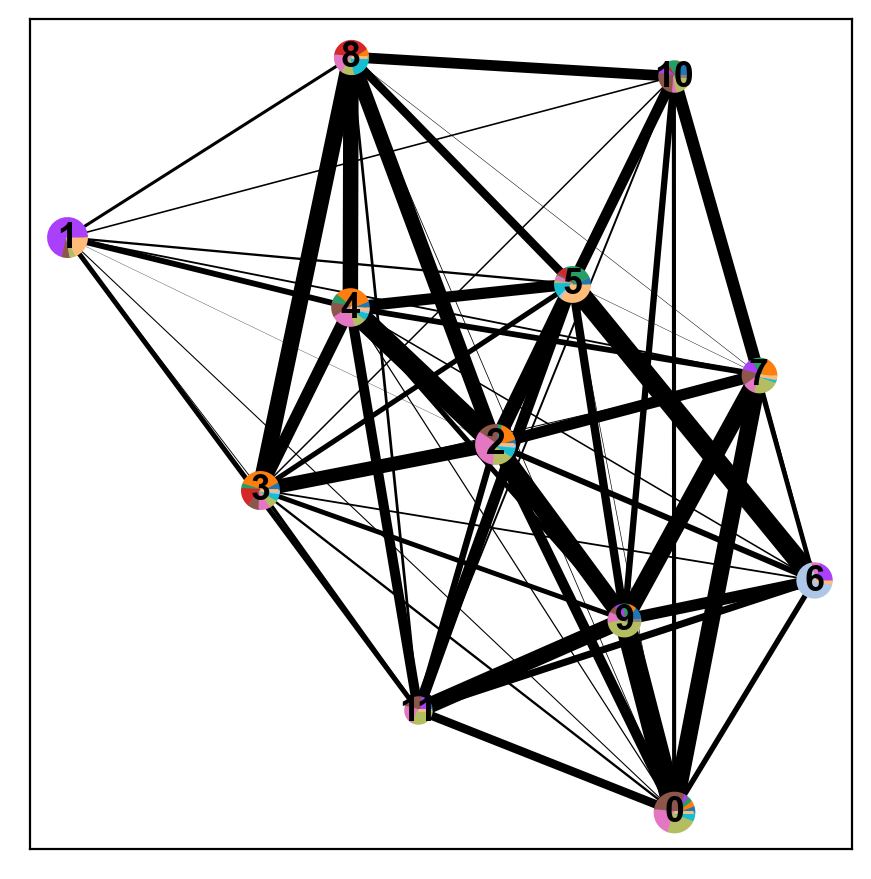

In [71]:
rcParams['figure.figsize'] = 5,5
qp.tl.paga(adata)
qp.pl.paga(adata, color=['GICS_Sector'], plot=True)

We can now map and view the annotations of leiden clustering or any financial metrics/features on the umap plots. Again, we can see that companies from the Leiden Clusters 8, 9, and 3 seems to perform the best 1 month post-vaccine-success, while the worst performers seem to be ones from the Clusters 6 and 7.

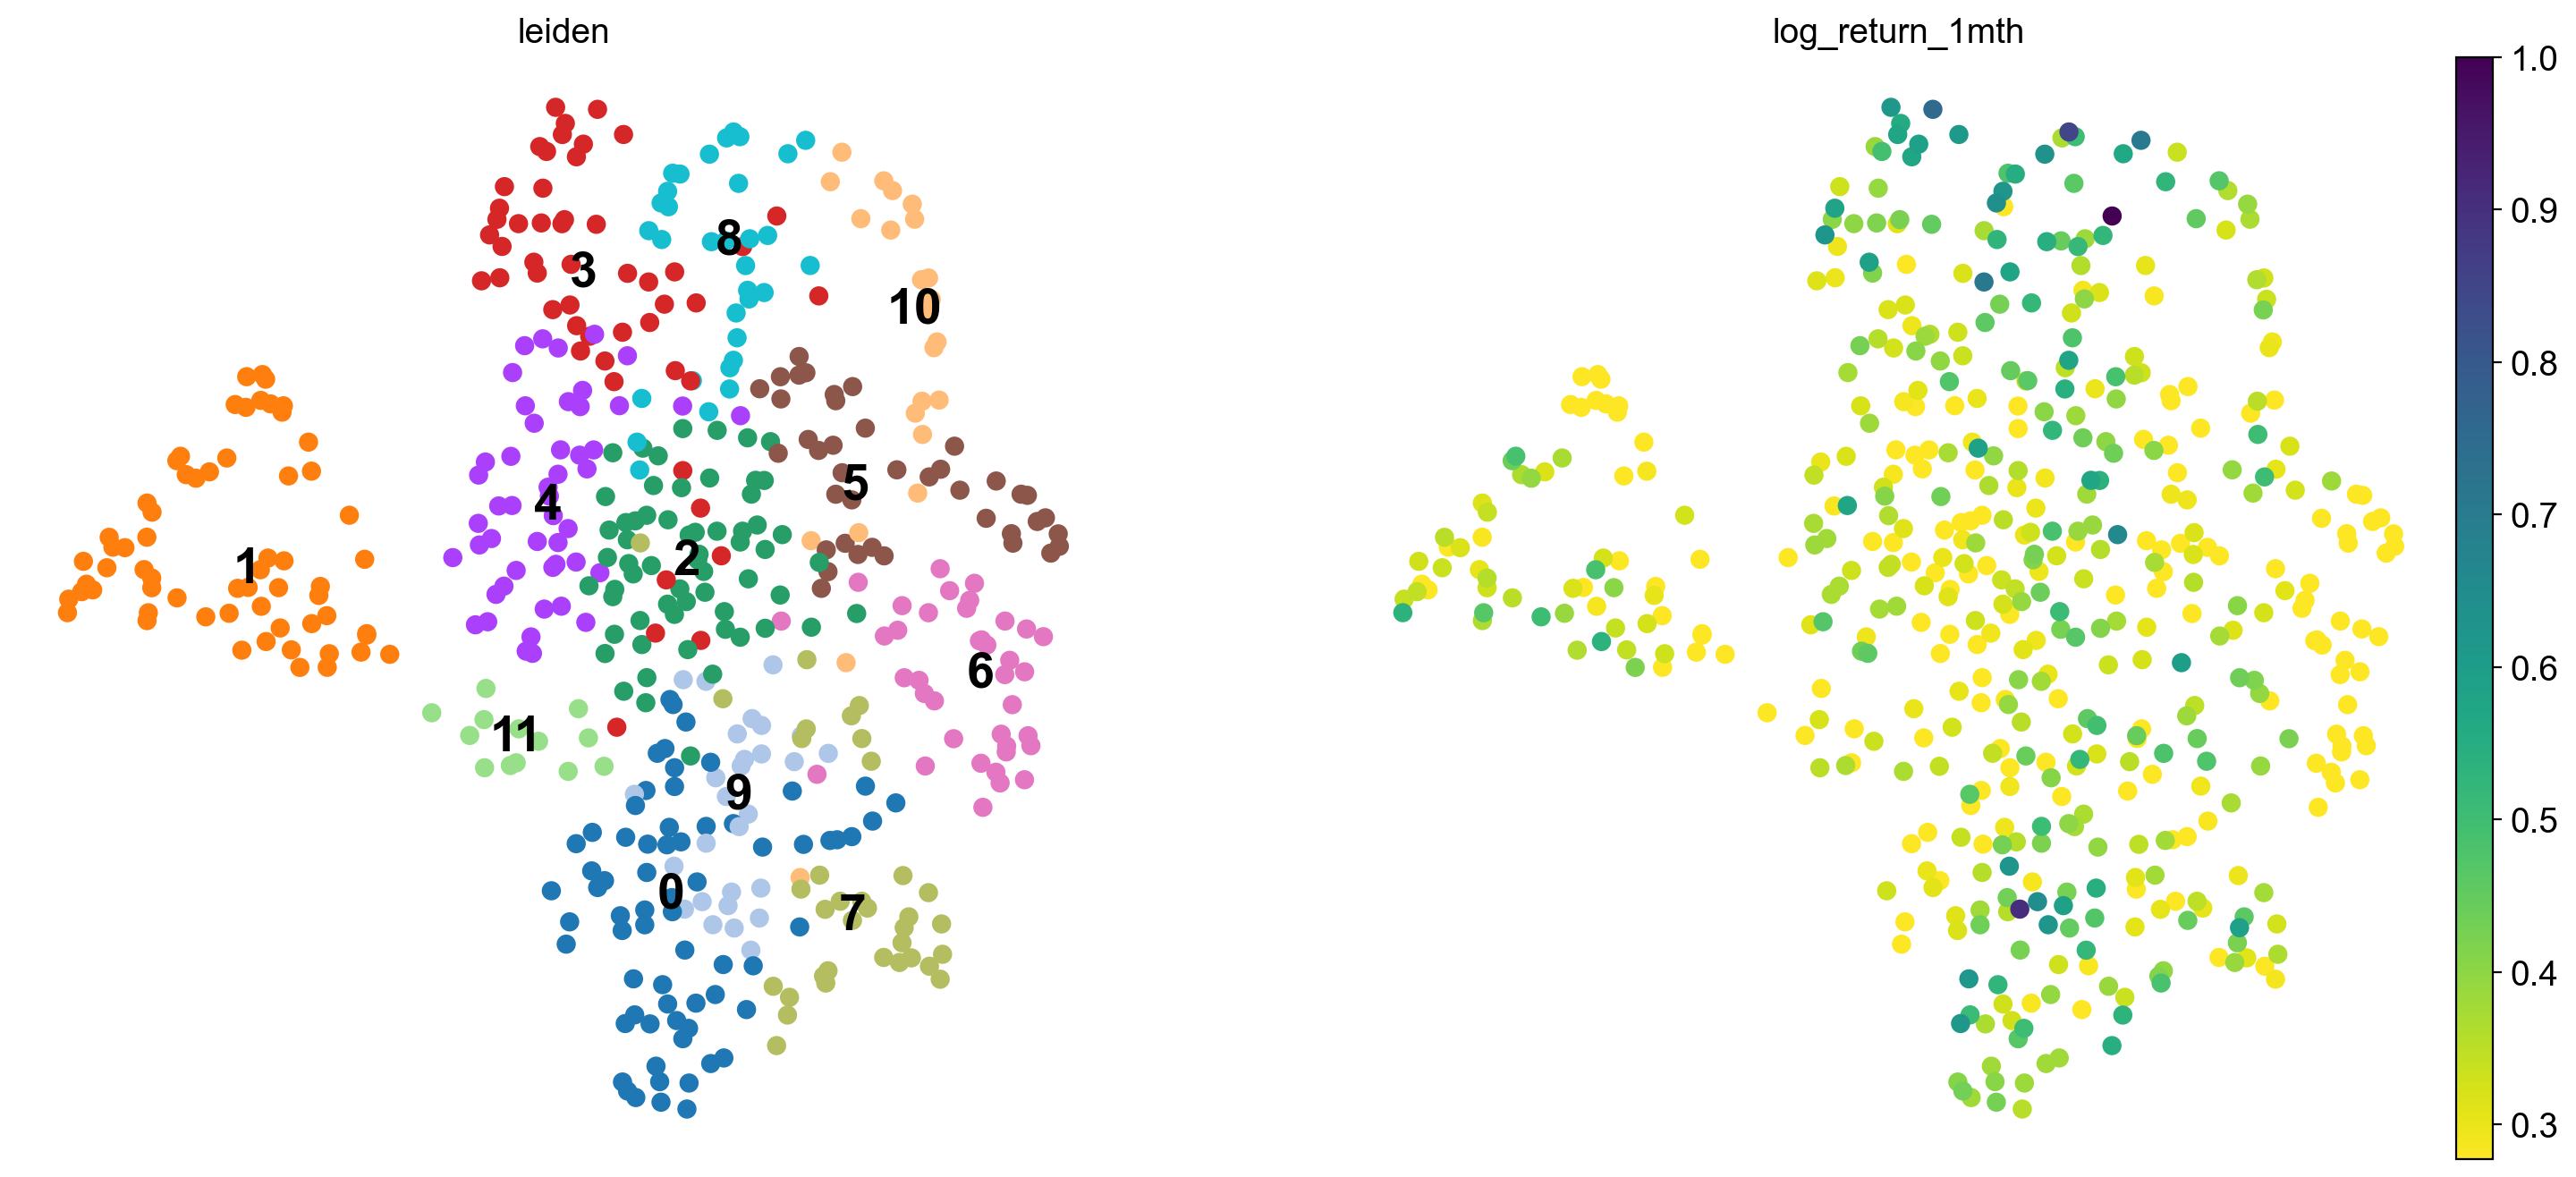

In [72]:
rcParams['figure.figsize'] = 8,8
qp.tl.umap(adata, init_pos='paga', random_state=42)
qp.pl.umap(adata, color=['leiden', 'log_return_1mth'], 
           legend_loc='on data', frameon=False, ncols=4, 
           vmin=0.277238, vmax=1.0, use_raw=True, legend_fontsize=20)

### Characterizing the clusters of companies

We run `qp.tl.dendrogram` to compute hierarchical clustering. Multiple visualizations that can
then include a dendrogram: `qp.pl.matrixplot`, `qp.pl.heatmap`, `qp.pl.dotplot` and `qp.pl.stacked_violin`. 

In [73]:
qp.tl.dendrogram(adata, 'leiden', var_names=adata.var_names);

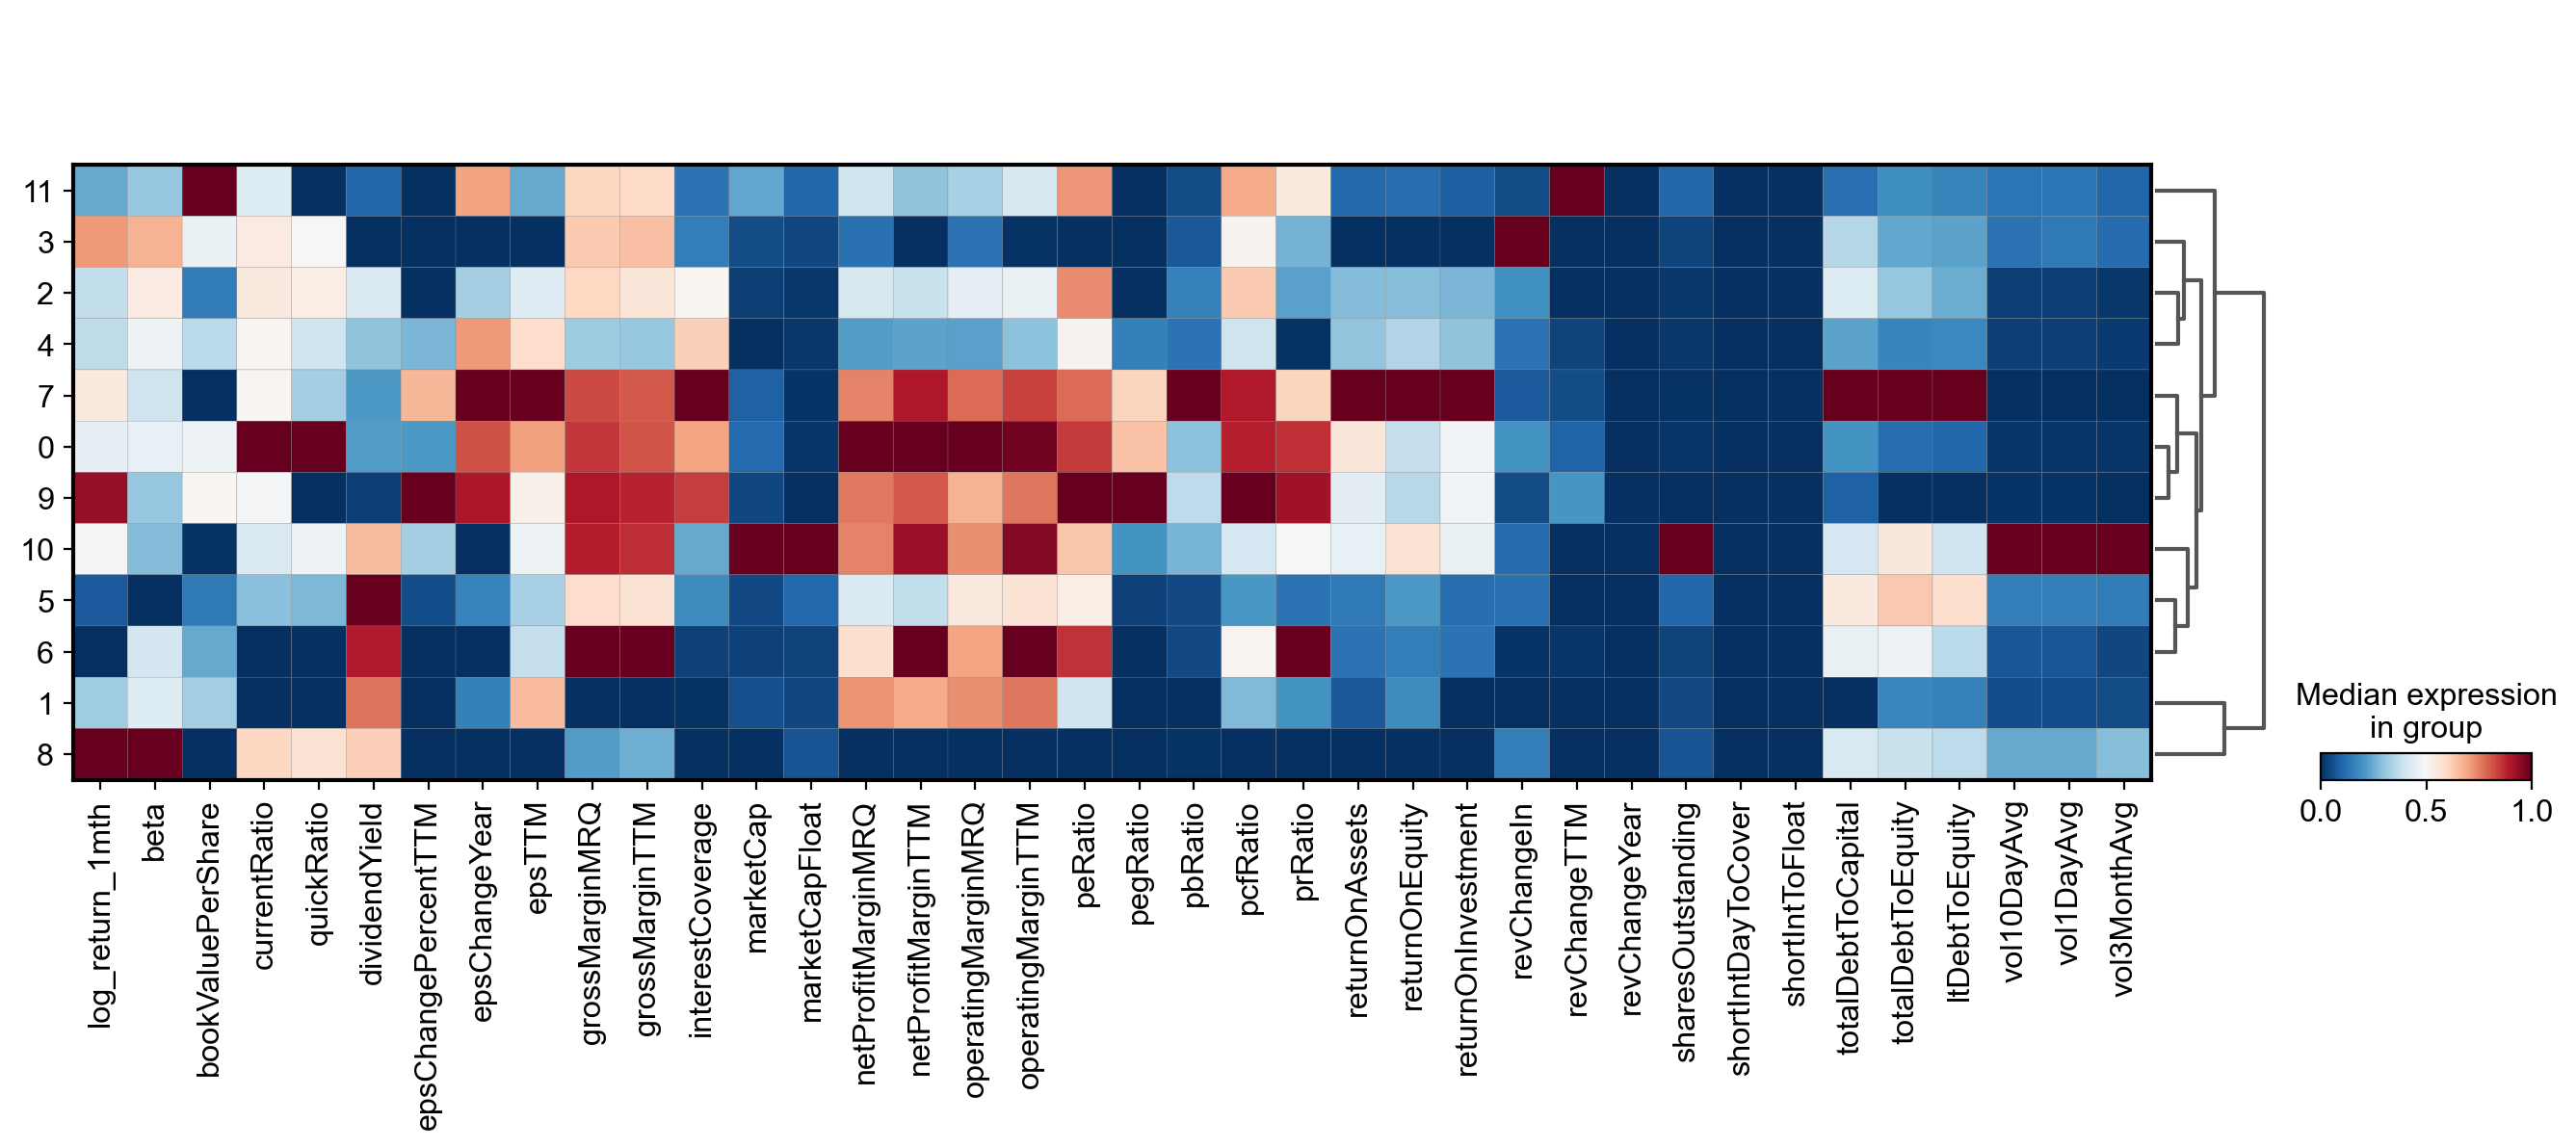

In [74]:
qp.pl.matrixplot(adata, var_names=adata.var_names, groupby='leiden', use_raw=True, 
              cmap='RdBu_r', dendrogram=True, standard_scale='var')

The matrixplot shows the median for each cluster/group of companies. Again, we are seeing Cluster 8 was the top performer in 'log_return_1mth', followed by Cluster 9, Cluster 3, and Cluster 7. Besides, we can also see that the 'beta' was high in both Cluster 8. In order to confirm the results, we are printing out the exact median values of log_return_1mth for each cluster/group of companies in dataframe.

In [75]:
df_leiden = pd.DataFrame(adata.obs['leiden'])
df_all = pd.merge(df_fundamental_logreturn, df_leiden, how='inner', left_index=True, right_index=True)

# sort clusters by median log_return_1mth
stats_perCluster = df_all.groupby(['leiden']).agg({'log_return_1mth': ['median', 'min', 
                     'max', 'mean']}).dropna()
stats_perCluster.columns = ['median', 'min', 'max', 'mean']
stats_perCluster.sort_values(['median'], ascending=False).style.background_gradient(cmap='bwr', axis=0)

Dataframe above shows that the median of 'log_return_1mth' was the highest in Leiden Cluster 8, while the lowest were Cluster 2. To confirm the 'beta', we did the similar in the following cell. We typically dislike [high beta as it usually means the company is more risky](https://www.investopedia.com/investing/beta-know-risk/).

In [76]:
# sort clusters by median beta
stats_perCluster = df_all.groupby(['leiden']).agg({'beta': ['median', 'min', 
                     'max', 'mean']}).dropna()
stats_perCluster.columns = ['median', 'min', 'max', 'mean']
stats_perCluster.sort_values(['median'], ascending=False).style.background_gradient(cmap='bwr', axis=0)

## Visualizing the important features defining each cluster
Instead of looking at all features of clusters as previously, we can identify features/metrics that are differentially characterizing each cluster. Here, we can see that the Cluster 8 was significantly positive-correlated with higher beta, volatility 3-month average (vol3MonthAvg), volatility 10-day average (vol10DayAvg), vol1DayAvg, but negatively associated with lower earning per share Trailing-twelve-month (epsTTM), price per earning ration (peRatio), operatingMarginTTM, netProfitMarginTTM, returnOnAssets, etc. 

The worst performer, Cluster 6, was associated with higher dividendYield, grossMarginMRQ, grossMarginTTM, TotalDebtToEquity, etc, and lower current, quick ratio, returnOnAssets, etc.

Here, the author is particularly interested in the companies from the Cluster 9, which associated with lower beta, that typically means that the stocks in this cluster are considered less risky. Also, the Cluster 9 were associated with favorable higher Operating Profitability Factors ('netProfitMarginTTM', 'netProfitMarginMRQ', 'grossMarginTTM', 'grossMarginMRQ', 'returnOnInvestment', 'returnOnAssets', 'operatingMarginTTM', 'operatingMarginMRQ') and lower Financial Risk Factors ('ITDebtToEquity' and 'TotalDebtToEquity')

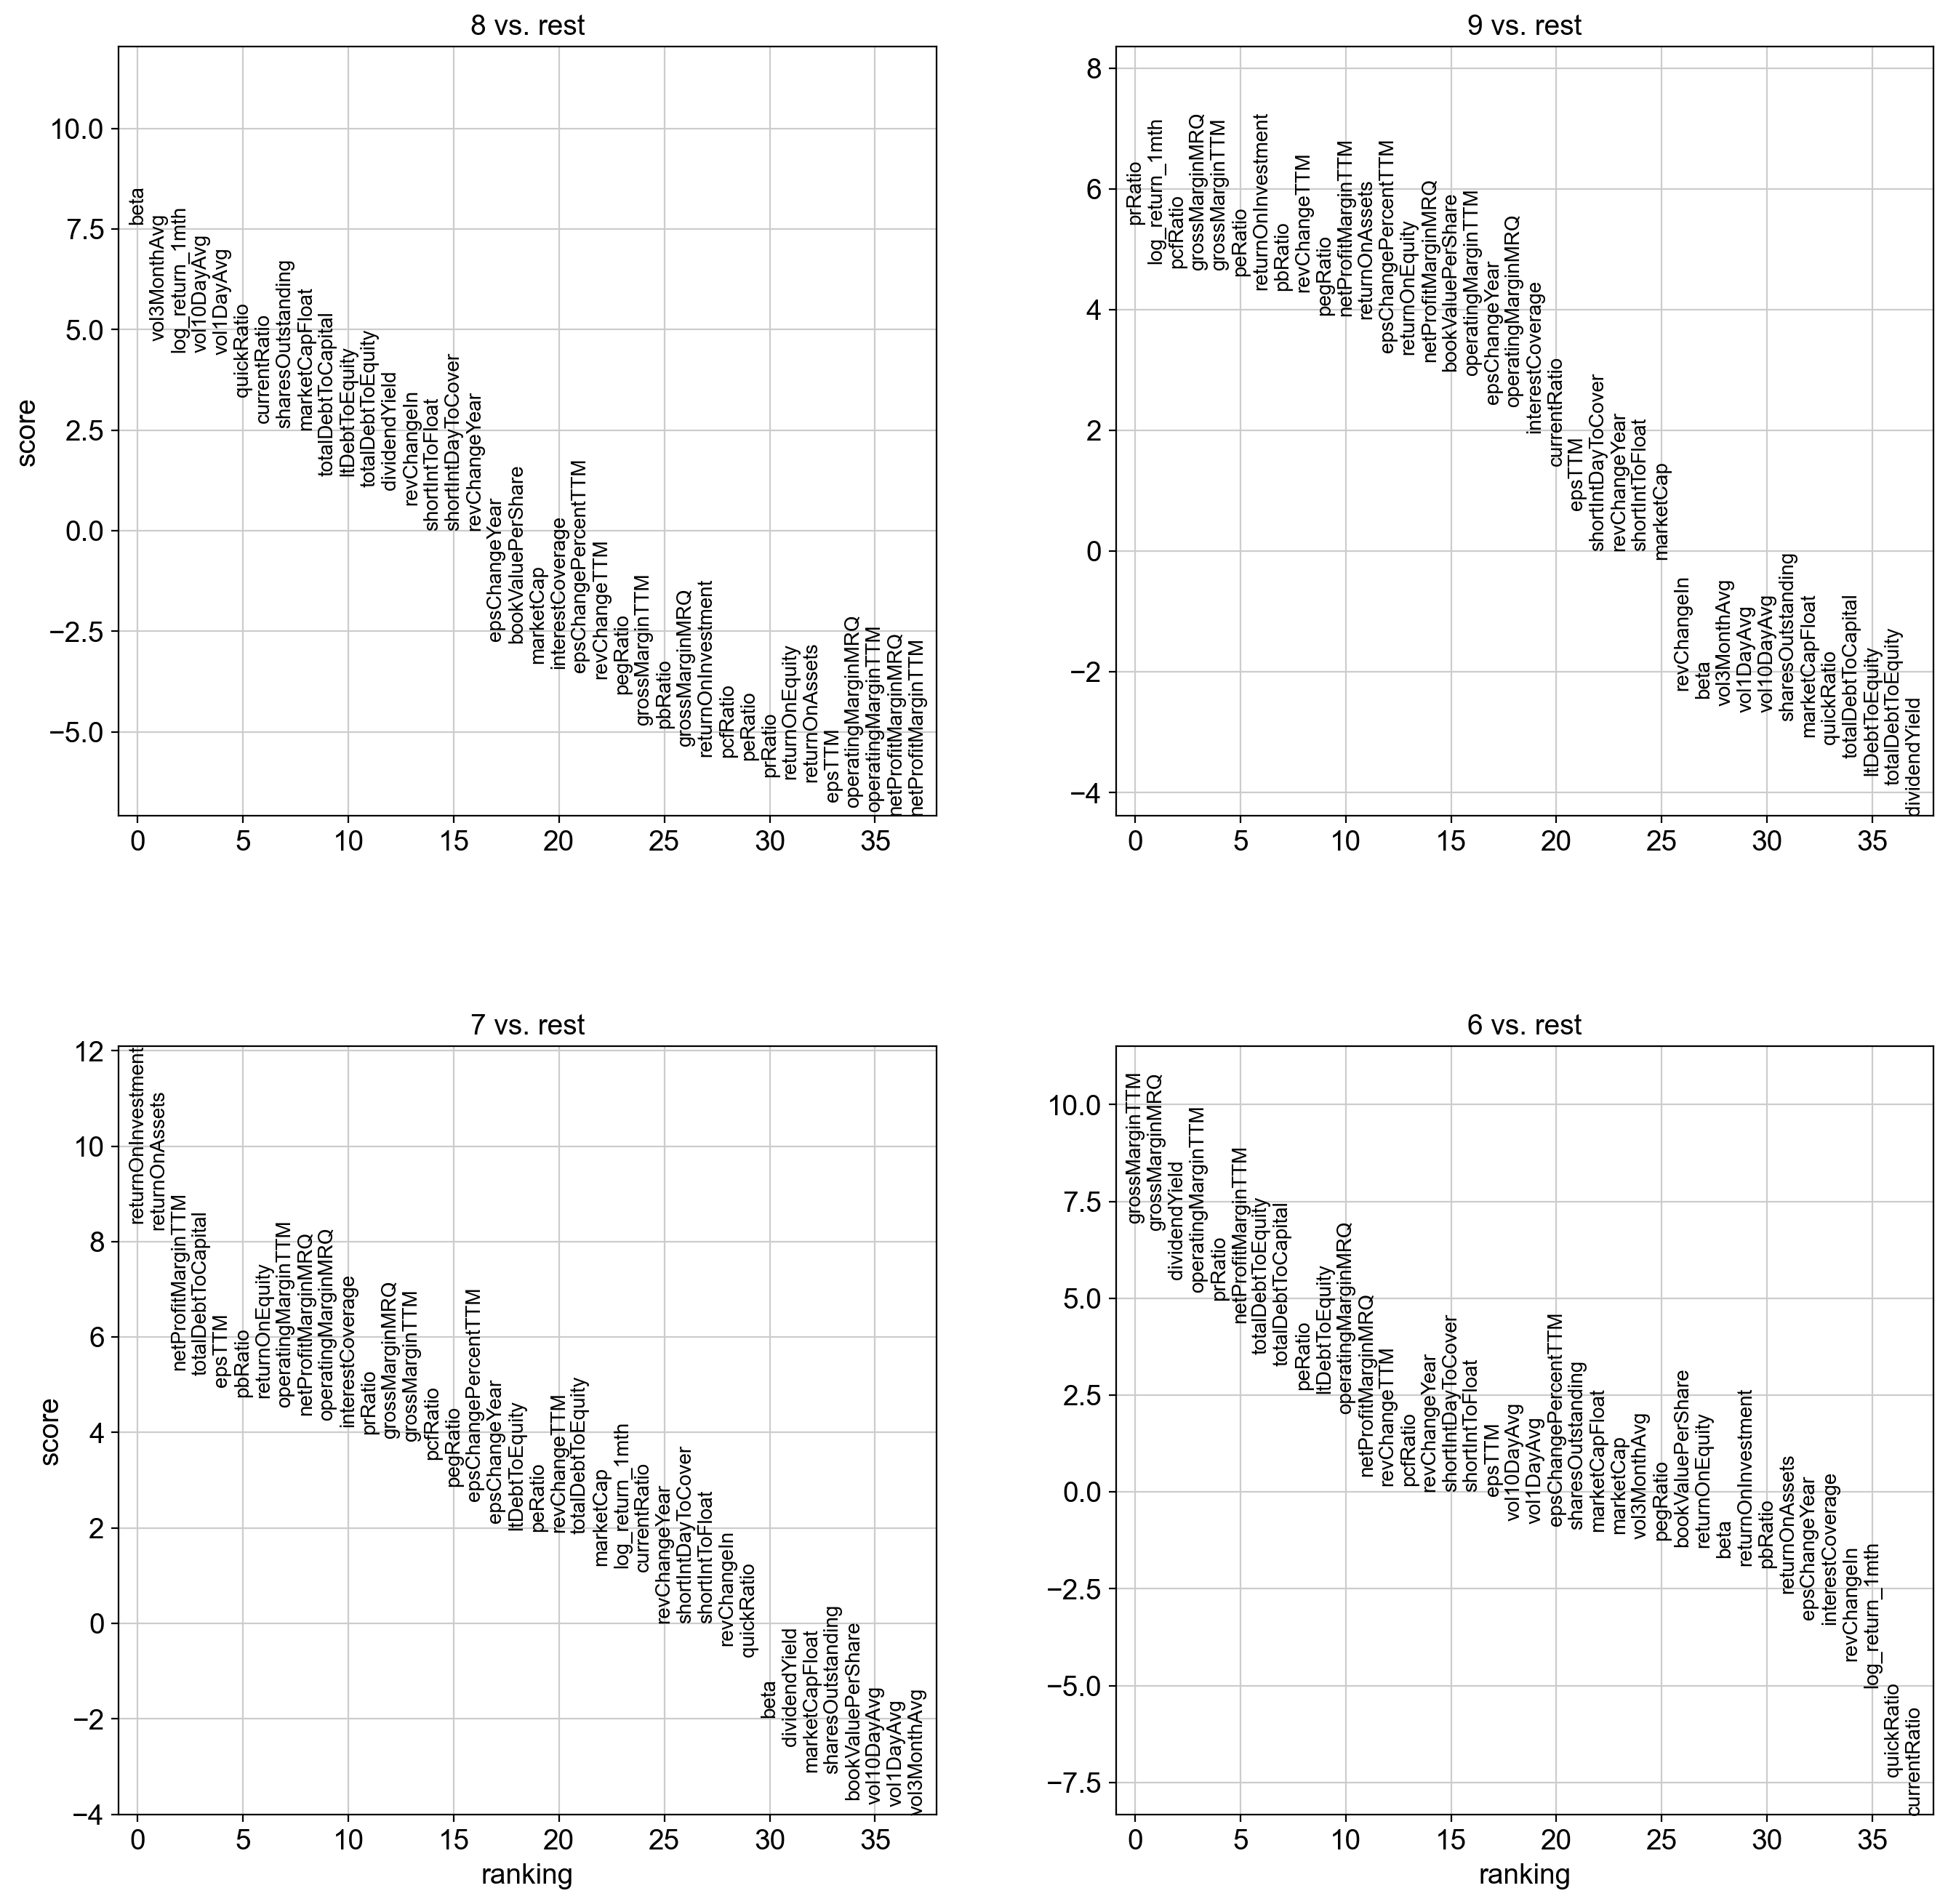

In [77]:
qp.tl.rank_features_groups(adata, 'leiden', groups=['8', '9', '7', '6'], method='wilcoxon')
qp.pl.rank_features_groups(adata, n_features=38, sharey=False, fontsize=10, ncols=2)

We can map and view the annotations of leiden clustering based on the financial metrics/features on the umap plots below. Here, we see that Leiden Cluster 8 was indeed mostly featured by high beta and unfavorable lower Operating Profitabiity Factors; Cluster 9 was featured by lower beta and many favourable higher Operating Profitability Factors; Clusters 6 and 7 were featured by unfavorable lower Solvency Factors (current, quick ratios).

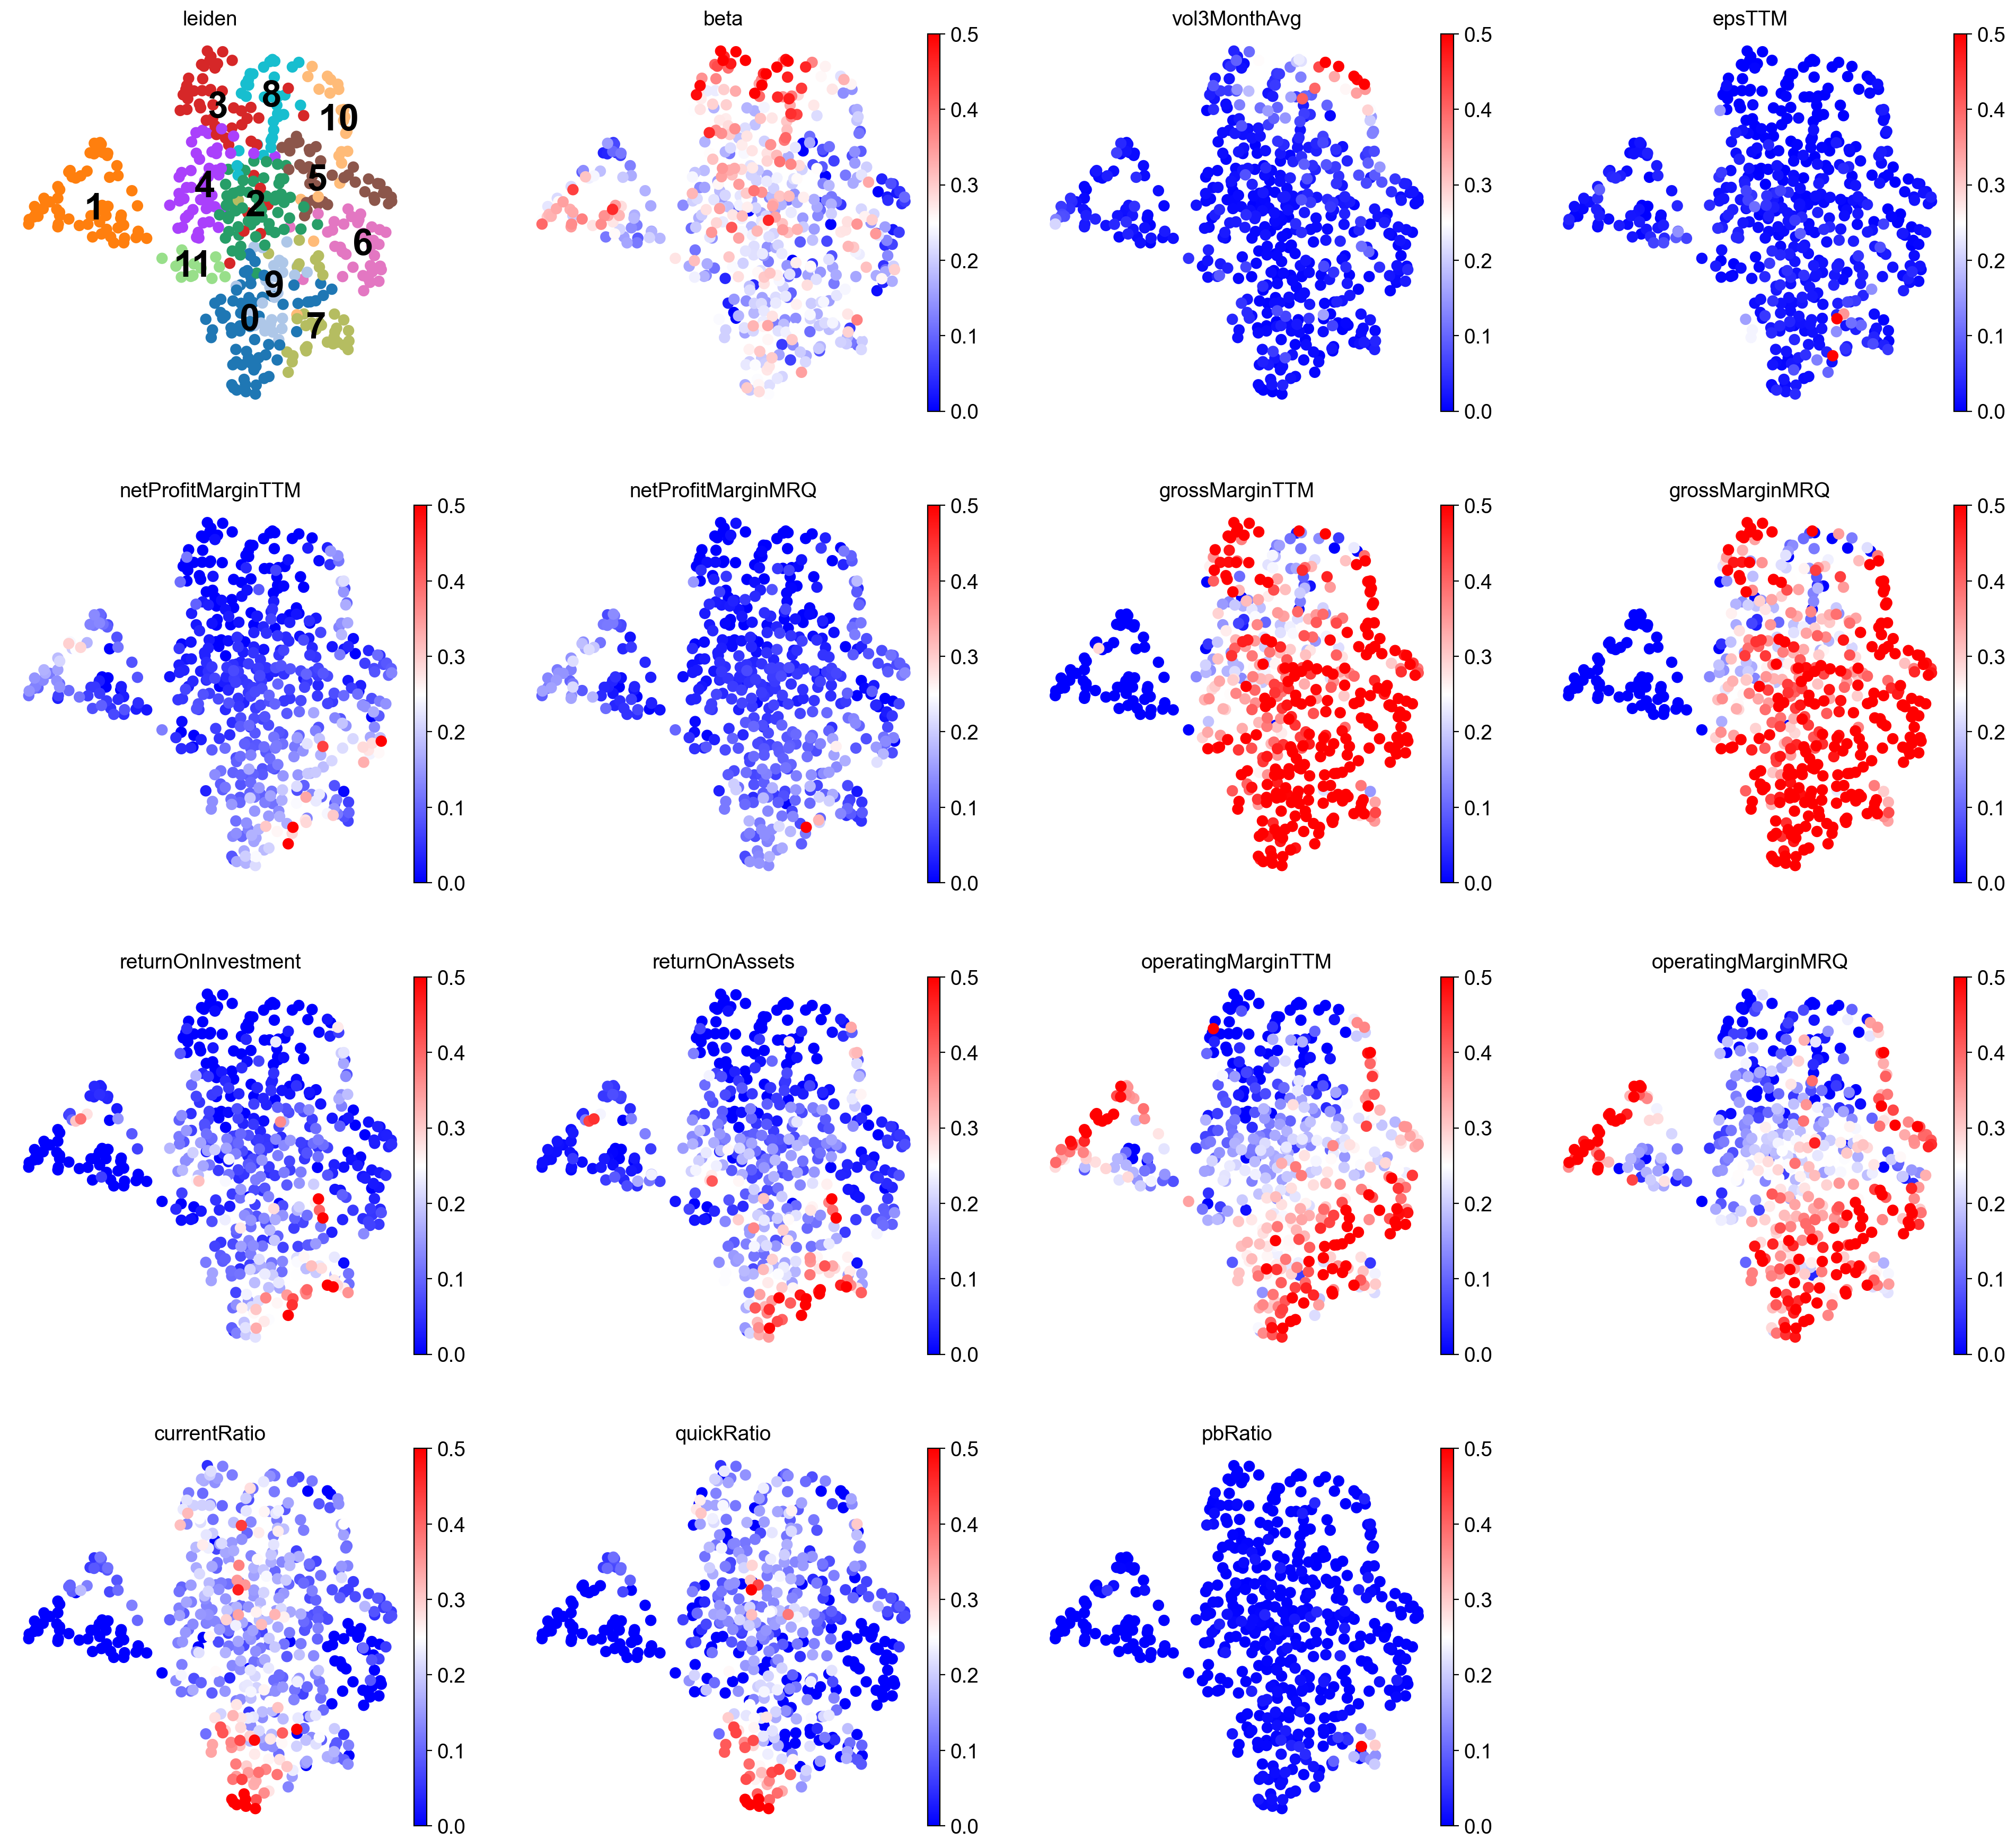

In [78]:
rcParams['figure.figsize'] = 5,5
qp.pl.umap(adata, color=['leiden', 'beta', 'vol3MonthAvg', 'epsTTM', 'netProfitMarginTTM', 
                         'netProfitMarginMRQ', 'grossMarginTTM', 'grossMarginMRQ', 
                         'returnOnInvestment', 'returnOnAssets', 'operatingMarginTTM', 
                         'operatingMarginMRQ', 'currentRatio', 'quickRatio', 'pbRatio'], 
           legend_loc='on data', frameon=False, ncols=4, cmap='bwr', vmax=0.5, legend_fontsize=25)

### Sector performance in the Cluster 9 companies

In [79]:
stats_perCluster = df_all.groupby(['leiden', 'GICS Sector']).agg({'log_return_1mth': ['median', 
                                                                   'min', 'max', 'mean']}).dropna()

stats_perCluster.columns = ['median', 'min', 'max', 'mean']
stats_perCluster = stats_perCluster.reset_index()
stats_perCluster[stats_perCluster.leiden == '6'].sort_values(['median'], ascending=False).\
                                                style.background_gradient(cmap='bwr', axis=0)

In [80]:
# Printing out Cluster 9 companies
heading_properties = [('font-size', '9px')]
cell_properties = [('font-size', '9.5px')]
dfstyle = [dict(selector="th", props=heading_properties),\
           dict(selector="td", props=cell_properties)]
df_all[df_all.leiden == '9'][['Security', 'GICS Sector', 'GICS Sub-Industry']].style.set_table_styles(dfstyle)

In [81]:
# Printing out Cluster 6 companies
heading_properties = [('font-size', '8px')]
cell_properties = [('font-size', ' 8px')]
dfstyle = [dict(selector="th", props=heading_properties),\
           dict(selector="td", props=cell_properties)]

df_all[df_all.leiden == '6'][['Security', 'GICS Sector', 'GICS Sub-Industry']].style.set_table_styles(dfstyle)

The sunburst chart below shows that Cluster 9 mostly consisted of Information Technology Sector, Cluster 10 mostly Energy Sector, Cluster 9 Financial Sector, and Cluster 2 Real Estate Sector.

In [49]:
import plotly.express as px

# grouping statistics
ds = df_all.groupby(['leiden', 'GICS Sector', 'GICS Sub-Industry'])['log_return_1mth'].count().reset_index()
ds.columns = ['leiden', 'GICS Sector', 'GICS Sub-Industry', 'count']

# plotting sunburst
fig = px.sunburst(
    ds, 
    path=[
        'leiden', 'GICS Sector', 'GICS Sub-Industry'
    ], 
    values='count', 
    title='Sunburst chart',
    width=900,
    height=900
)
fig.show()

The sunburst chart below shows that most of the Real Estate companies Fall on the worst performer 1-month post vaccine success, Cluster 6.

In [55]:
import plotly.express as px
from itertools import repeat

Other_clusters = [c for c in df_all.leiden.unique() if c not in ['8', '9', '7', '6']]
dict_regroup = {key: item for key, item in zip(Other_clusters, repeat('Others'))}
dict_regroup['8'] = 'C8 - Top performer'
dict_regroup['9'] = 'C9 - Second top (ideal) performer'
dict_regroup['7'] = 'C7 - Second to Worst performer'
dict_regroup['6'] = 'C6 - Worst performer'

df_regrouped = df_all.replace({'leiden': dict_regroup})

# grouping statistics
ds = df_regrouped.groupby(['GICS Sector', 'leiden'])['log_return_1mth'].count().reset_index()
ds.columns = ['GICS Sector', 'leiden', 'count']

# plotting sunburst
fig = px.sunburst(
    ds, 
    path=[
        'GICS Sector','leiden'
    ], 
    values='count', 
    title='Sunburst chart',
    width=700,
    height=700
)
fig.show()

## Conclusions:-
In this tutorial, we found that although the Cluster 8 was the top performer but it was associated with high beta companies — higher risk in stock market. Their performance were unjustifiable with statistically lower Operating Profit Factor. In comparison, Cluster 9 companies have lower beta — less risky, and its performance is justified by favourable higher Operating Profit Factor and lower Financial Risk Factors.

On the other hand, the worst performer was the Cluster 6, followed by Cluster 7. Both clusters have significantly lower solvency (current and quick ratios). Cluster 6 was also associated with higher financial risk, i.e. higher debt-to-capital/Equity. Of note, the cluster 6 was consisted mainly of the Real Estate companies. The worst performance probably justified by the on-going second wave during the current winter season, where city lockdown is widely adopted.

REFERENCES:
1. https://quanp.readthedocs.io/en/latest/tutorials.html
2. Tabachnick & Fidell. Using Multivariate Statistics, Sixth Edition. PEARSON 2013; ISBN-13:9780205956227.
3. Traag et al. (2018), From Louvain to Leiden: guaranteeing well-connected communities arXiv.
4. Chincarini & Kim. Quantitative Equity Portfolio Management — An Active Approach to Portfolio Construction and Management. McGraw-Hill 2006; ISBN:0071459405.